In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import joblib
import datetime

In [2]:
TRAIN_SET = "data\\Train.csv"

In [3]:
df = pd.read_csv(TRAIN_SET)
df = df.fillna(df.median(numeric_only=True).round())
df = df.dropna(how="any")
df = df.drop("ID", axis=1)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


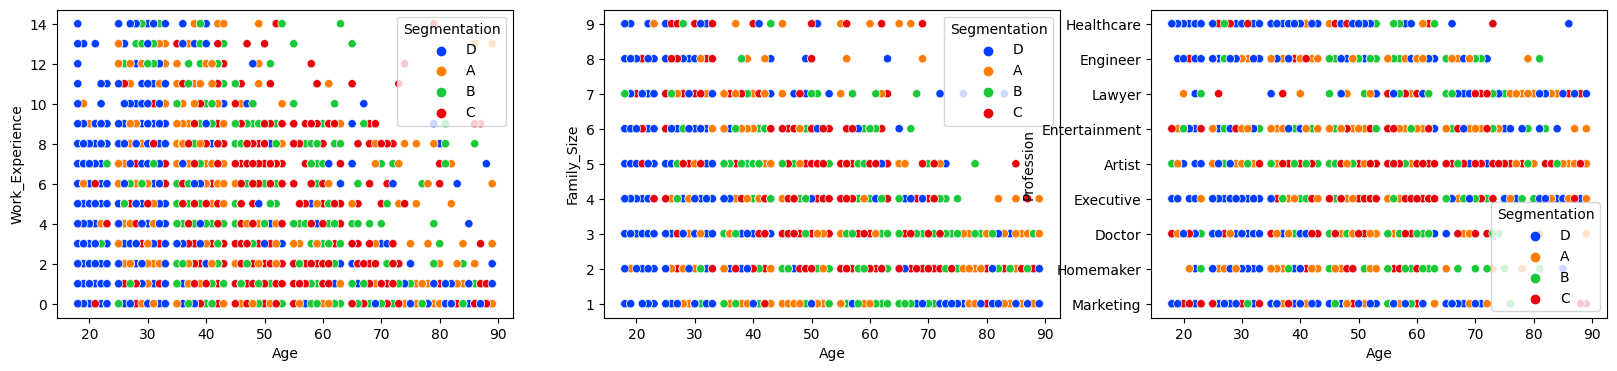

In [4]:
def plot_data():
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    sns.scatterplot(data=df, ax=axes[0], x="Age", y="Work_Experience", hue="Segmentation", palette="bright")
    sns.scatterplot(data=df, ax=axes[1], x="Age", y="Family_Size", hue="Segmentation", palette="bright")
    sns.scatterplot(data=df, ax=axes[2], x="Age", y="Profession", hue="Segmentation", palette="bright")

plot_data()

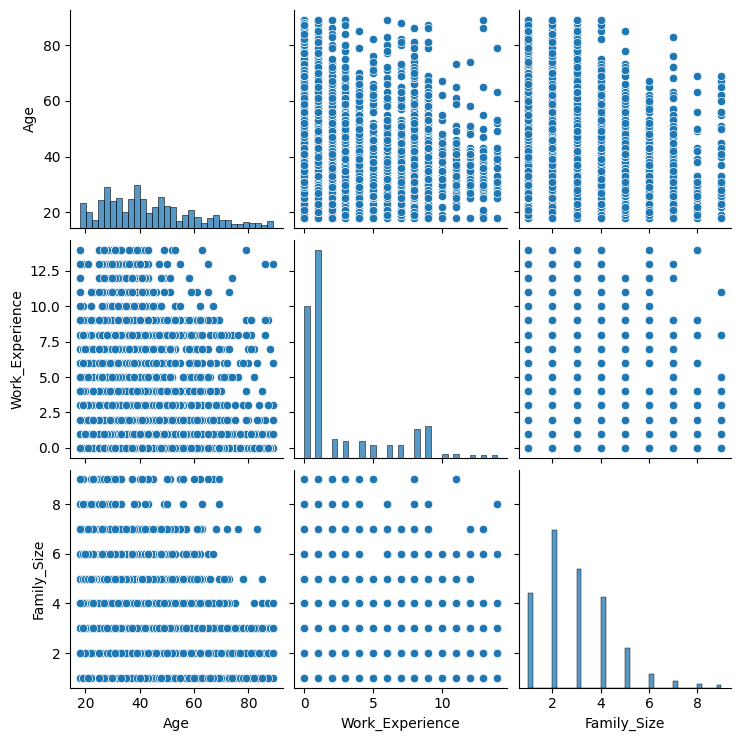

In [5]:
sns.pairplot(df)

<AxesSubplot:>

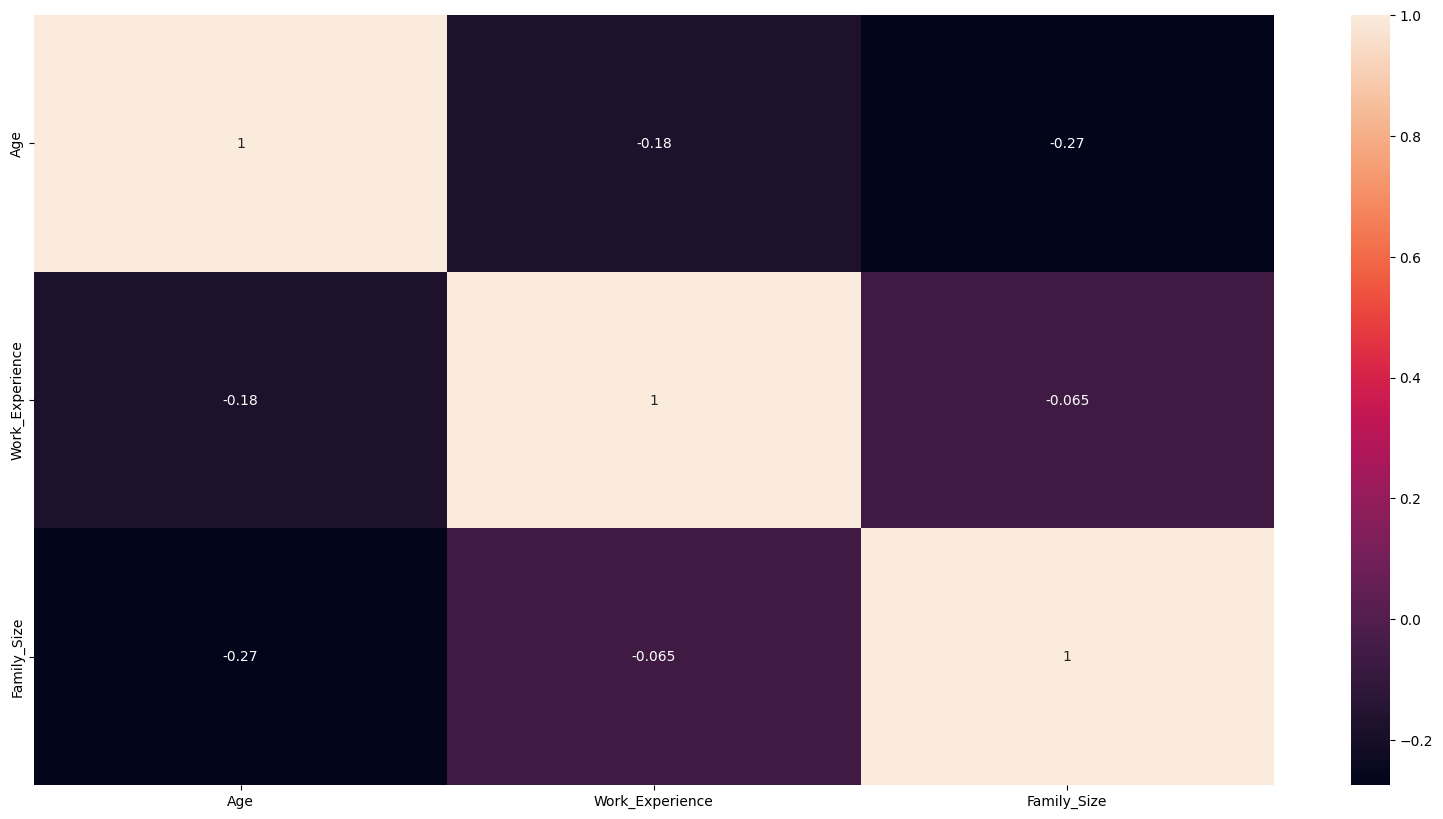

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

In [7]:
num_df = pd.DataFrame(zip(df.Age, df.Work_Experience, df.Family_Size))
scaler = StandardScaler()
df_scaled = scaler.fit_transform(num_df)

In [8]:
pca = PCA(n_components=2)
num_df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=['PCA1', 'PCA2'])

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

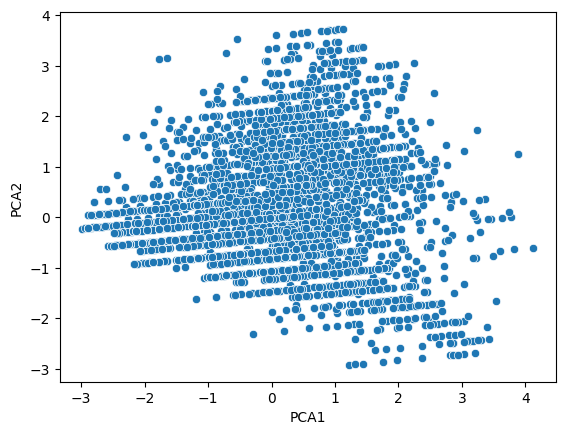

In [9]:
sns.scatterplot(x=num_df_pca.PCA1, y=num_df_pca.PCA2)

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

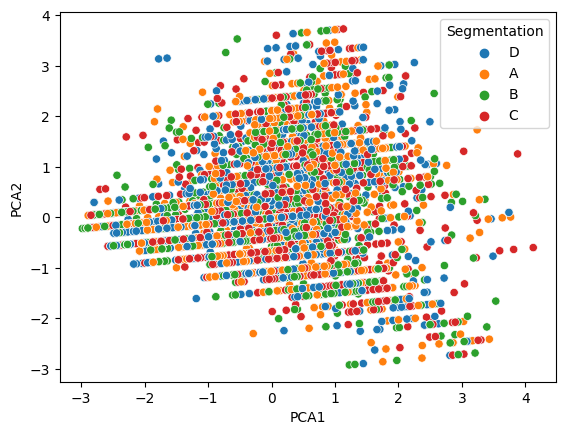

In [10]:
sns.scatterplot(x=num_df_pca.PCA1, y=num_df_pca.PCA2, hue=df["Segmentation"])

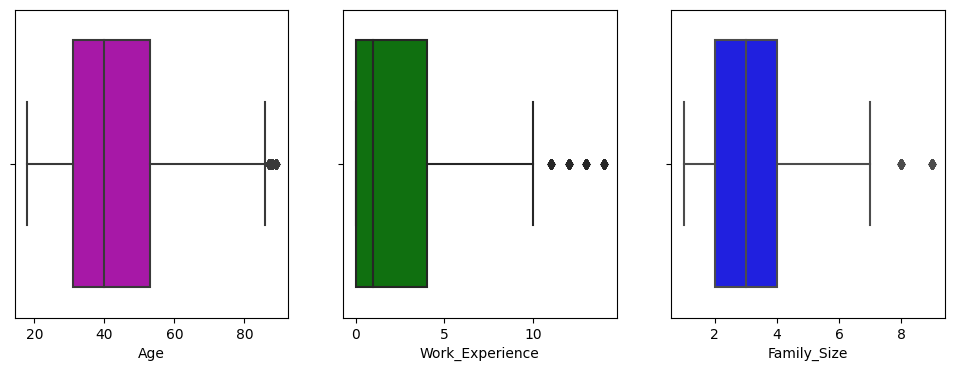

In [11]:
def plot_boxes():
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.boxplot(ax=axes[0], x=df["Age"], palette=["m"])
    sns.boxplot(ax=axes[1], x=df["Work_Experience"], palette=["g"])
    sns.boxplot(ax=axes[2], x=df["Family_Size"], palette=["b"])

plot_boxes()

In [12]:
def remove_outliers(df:pd.DataFrame, column:str, z_score:int):
    z = abs(stats.zscore(df[column]))
    df = df[(z < z_score)]
    return df

df = remove_outliers(df, "Age", 2)
df = remove_outliers(df, "Work_Experience", 3)
df = remove_outliers(df, "Family_Size", 3)

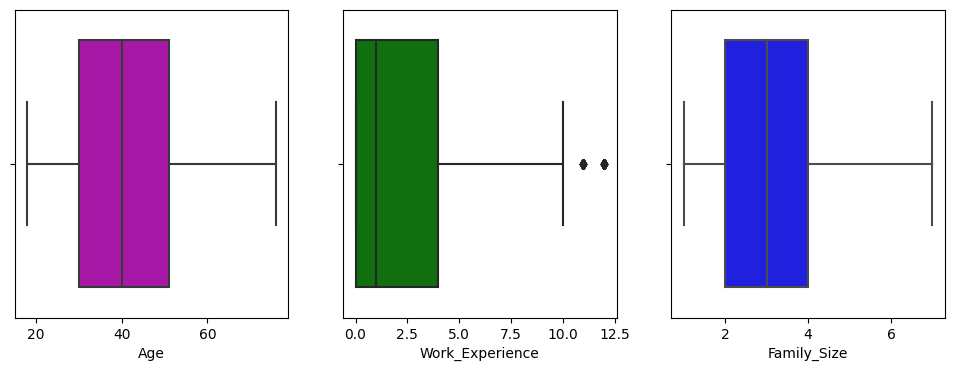

In [13]:
plot_boxes()

In [14]:
df["Segmentation"] = df["Segmentation"].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3})
y = df.pop("Segmentation")

non_numeriacal = ["Gender", "Ever_Married", "Graduated",
                  "Profession", "Spending_Score", "Var_1"]
x = pd.get_dummies(df, columns=non_numeriacal)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    stratify=y, 
                                                    test_size=0.8, 
                                                    random_state=42)

In [16]:
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=4)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])

In [17]:
nca_pipe.fit(x_train, y_train)

Pipeline(steps=[('nca', NeighborhoodComponentsAnalysis(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=4))])

In [18]:
now = datetime.datetime.now()
sv = now.strftime("%Y%m%d_%H%M") 
joblib.dump(nca_pipe, f"models/{sv}_kkn_model.joblib")

['models/20230426_1001_kkn_model.joblib']

In [19]:
print(nca_pipe.score(x_test, y_test))

0.4496656107004576


In [20]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x, y)

SVC()

In [21]:
print(clf.score(x_test, y_test))

0.46972896867300246


In [22]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-6,
                   hidden_layer_sizes=[512, 128], random_state=1)
nn.fit(x_train, y_train)

MLPClassifier(alpha=1e-06, hidden_layer_sizes=[512, 128], random_state=1)

In [23]:
print(nn.score(x_test, y_test))

0.48011263639563534


In [ ]:
ld = joblib.load("models/20230422_2323_kkn_model.joblib")
print(ld.score(x_test,y_test))
print(ld.predict(x_test))